In [6]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
## !! CHANGE ME !! ##
from suite2p.io import lbm as lbmio
from suite2p.suite3d import utils
from suite2p.suite3d.job import Job
from suite2p.suite3d import ui

os.chdir('/home/ali/packages/s2p-lbm/')
from utils import tiff_utils as tfu
from utils import file_utils as flu

In [8]:
# Create the job
job = Job('/mnt/md0/runs','AH007_2022-03-28_2-4-5', create=False, overwrite=False, verbosity = 10)

   Found and loaded params from /mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/params.npy


In [10]:
svd_dir_tag = 'svd'
svd_info = n.load(os.path.join(job.dirs[svd_dir_tag], 'svd_info.npy'),allow_pickle=True).item()

In [54]:
zidx = 5

In [144]:
ct = (0,400)
mov3d = job.get_registered_movie('registered_fused_data', 'fused')
cz, cy, cx = job.params['svd_crop']
mov3d = mov3d[cz[0]:cz[1], ct[0]:ct[1], cy[0]:cy[1], cx[0]:cx[1]]
ccy, ccx = ((200, 800), (300,900))

mov3d = mov3d[:,:,ccy[0]:ccy[1], ccx[0]:ccx[1]]
im = mov3d[zidx, :].mean(axis=0).compute()
mov = mov3d[zidx].compute()

In [313]:
params = {
    't_batch_size' : 400,
    'temporal_hpf' : 400,
    
    'npil_filt_type' : 'gaussian',
    'npil_filt_xy' : 4,
    'npil_filt_z' : 0.85,
    
    'conv_filt_type' : 'gaussian',
    'conv_filt_xy' : 0.5,
    'conv_filt_z' : 0.85,
    
    'intensity_thresh' : 0,
    'sdnorm_exp' : 0.8,
    
    'n_proc_corr' : 32,
    'mproc_batchsize' : None,
    'dtype' : n.float32,
    
}

In [162]:
from suite2p.suite3d import iter_step
from suite2p.detection import detection3d as det3d
from suite2p.detection import utils as detu
from scipy import ndimage

In [315]:
np_size = (0,0.85,4,4)
cv_size = (0,0.85,0.5,0.5)
int_thresh = 0
hpf_width = 400
sdnorm_exp = 0.8
np_filt = ndimage.gaussian_filter
cv_filt = ndimage.gaussian_filter

In [347]:
vmap2_og = n.zeros((nz,ny,nx)); sdmov2_og = n.zeros((nz,ny,nx))
mean_img = n.zeros((nz,ny,nx)); max_img = n.zeros((nz,ny,nx))
(norm_mov_og, cv_mov_og, np_sub_mov_og) = iter_step.calculate_corrmap_for_batch(movx.copy(), 
                                      sdmov2_og, vmap2_og, mean_img, max_img,
                                      hpf_width, np_size[1:], cv_size[1:], int_thresh, nt, 30, 20,
                                      return_mov_filt=True, fix_vmap_edges=False, sdnorm_exp=sdnorm_exp,
                                      conv_filt_type='gaussian', np_filt_type='gaussian', dtype=n.float32)
vmap_og = vmap2_og ** 0.5
vmap_og2, __, __ = iter_step.calculate_corrmap(mov[n.newaxis], params, None, save=False)

Rolling mean filter
Stdev over time
Sharr creation
Sub and conv
Vmap
Using conv_filt: gaussian, 0.85, 0.50
Using np_filt: gaussian, 0.85, 4.00
Running batch 1 of 1
Loaded and swapped, idx 0 to 400
Calculating corr map
Rolling mean filter
Stdev over time
Sharr creation
Sub and conv
Vmap
Calculated corr map in 3.57 seconds


In [339]:
movx = mov[n.newaxis].copy().swapaxes(0,1).astype(n.float32)
nt,nz,ny,nx = movx.shape
# mov_hpf = detu.hp_rolling_mean_filter(movx, hpf_width)
# sdmov2 = det3d.standard_deviation_over_time(mov_hpf, nt, sqrt=False)
mov_hpf = n.zeros_like(movx)
for i in range(0, nt, hpf_width):
    mov_hpf[i:i+hpf_width] = movx[i:i+hpf_width] - movx[i:i+hpf_width].mean(axis=0)
sdmov = (((n.diff(mov_hpf, axis=0) ** 2).sum(axis=0)) / nt)**0.5

In [344]:
norm_mov = mov_hpf.copy() / (sdmov ** sdnorm_exp)
c1 = np_filt(n.ones((nz,ny,nx)), np_size[1:], mode='constant')
c2 = cv_filt(n.ones((nz,ny,nx)), cv_size[1:], mode='constant')
np_mov = npfilt(norm_mov, np_size, mode='constant') / c1
np_sub_mov = norm_mov - np_mov
cv_mov = cvfilt(np_sub_mov, (cv_size), mode='constant') * cv_size[-1]
vmap = ((cv_mov ** 2) * (cv_mov > int_thresh).astype(int)).sum(axis=0) ** 0.5

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f0517ccb1f0>)

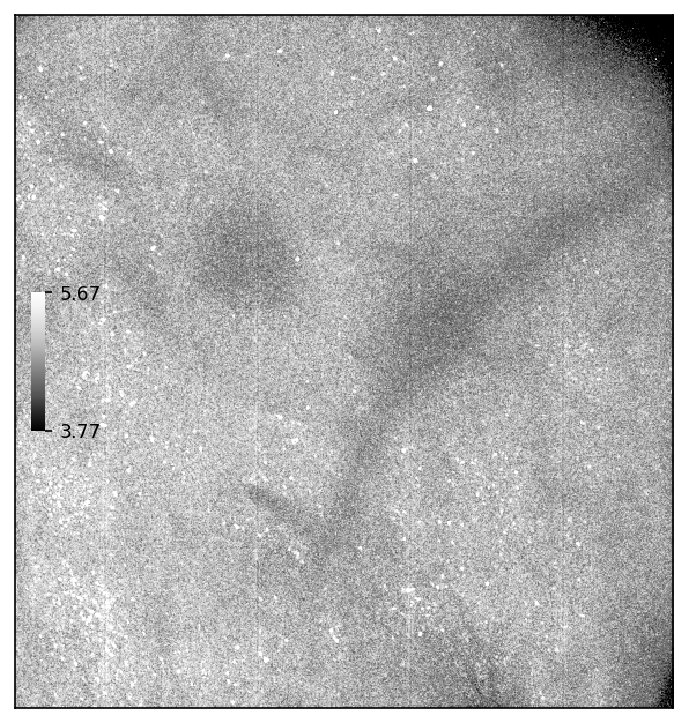

In [348]:
tfu.show_tif(vmap_og2[0], cbar=True)

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f0515c9f4f0>)

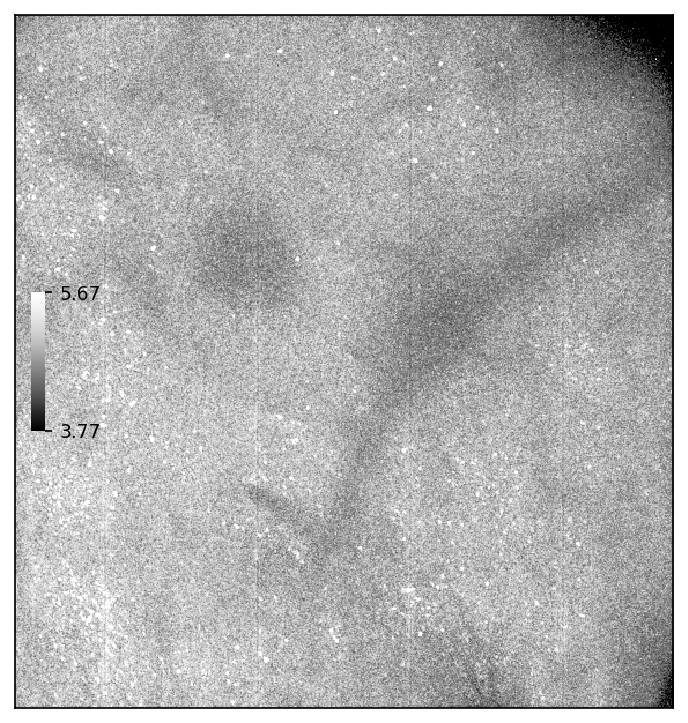

In [345]:
tfu.show_tif(vmap_og[0], cbar=True)

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f0515bc6610>)

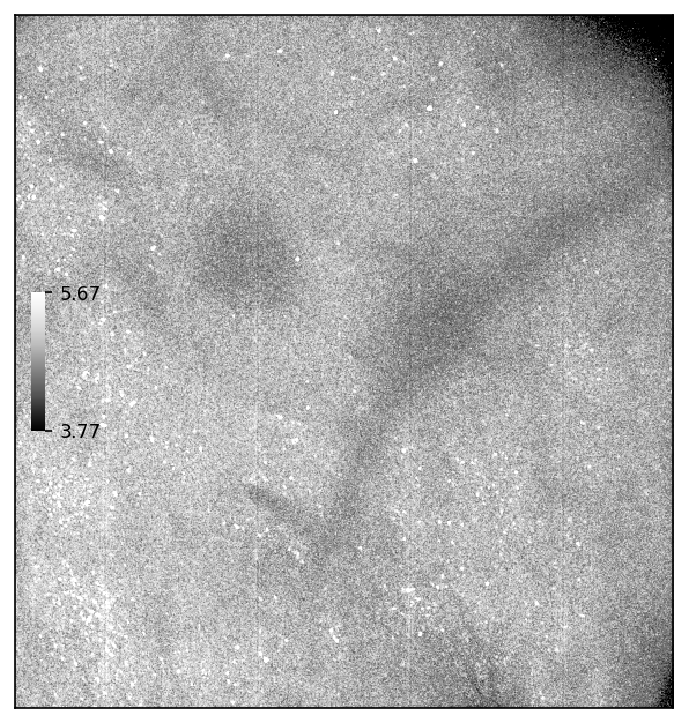

In [346]:
tfu.show_tif(vmap[0], cbar=True)

In [305]:
# sdmov_exponents = (0, 0.7,0.8,0.9,1.0)

# vmaps = []
# for sdmov_exponent in sdmov_exponents:
#     print(sdmov_exponent)
#     if sdmov_exponent == 0 :
#         norm_mov = mov_hpf.copy()
#     norm_mov = mov_hpf.copy() / (sdmov ** sdmov_exponent)
#     c1 = np_filt(n.ones((nz,ny,nx)), np_size[1:], mode='constant')
#     c2 = cv_filt(n.ones((nz,ny,nx)), cv_size[1:], mode='constant')
#     np_mov = npfilt(norm_mov, np_size, mode='constant') / c1
#     np_sub_mov = norm_mov - np_mov
#     cv_mov = cvfilt(np_sub_mov, (cv_size), mode='constant') * cv_size[-1]
#     vmap = ((cv_mov ** 2) * (cv_mov > int_thresh).astype(int)).sum(axis=0) ** 0.5
#     vmaps.append(vmap)

Text(0.5, 1.0, 'Mean')

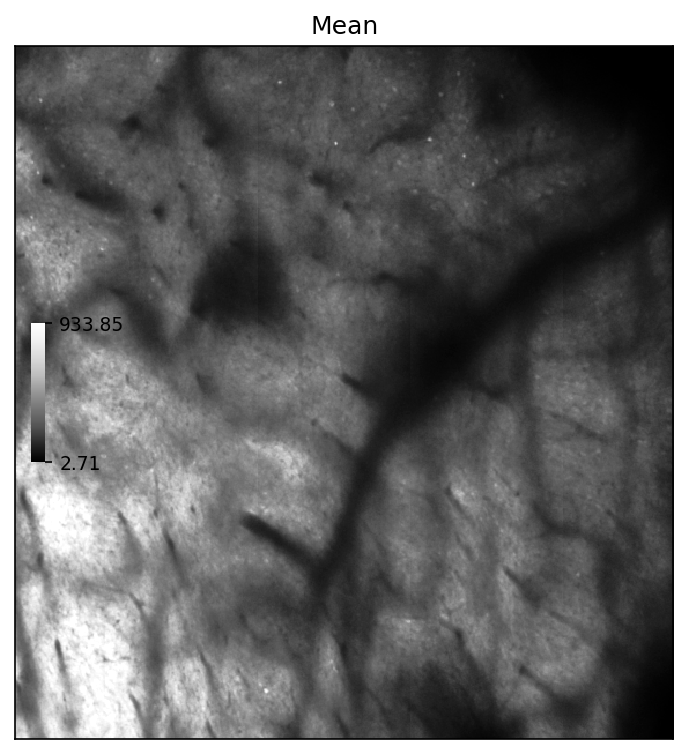

In [309]:
mean_img = movx.mean(axis=0)
tfu.show_tif(mean_img[0], cbar=True)
plt.title("Mean")

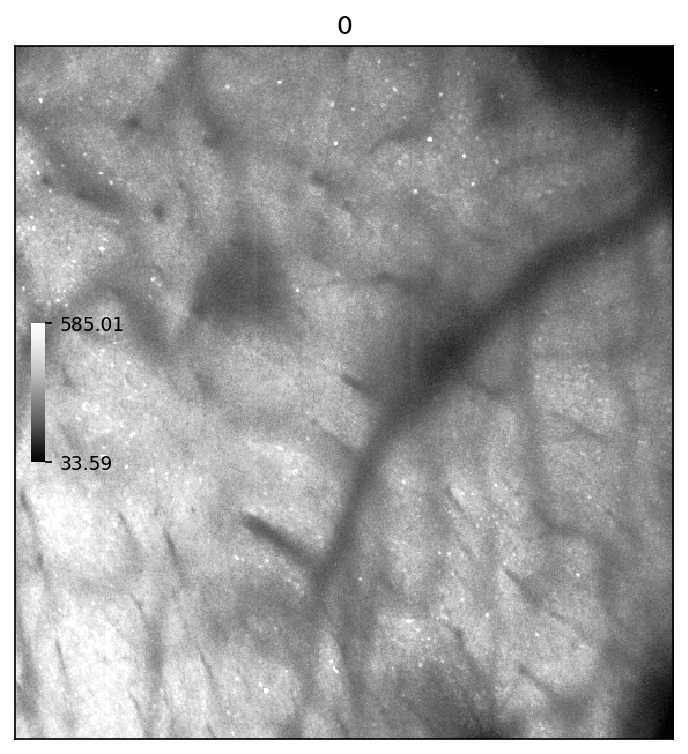

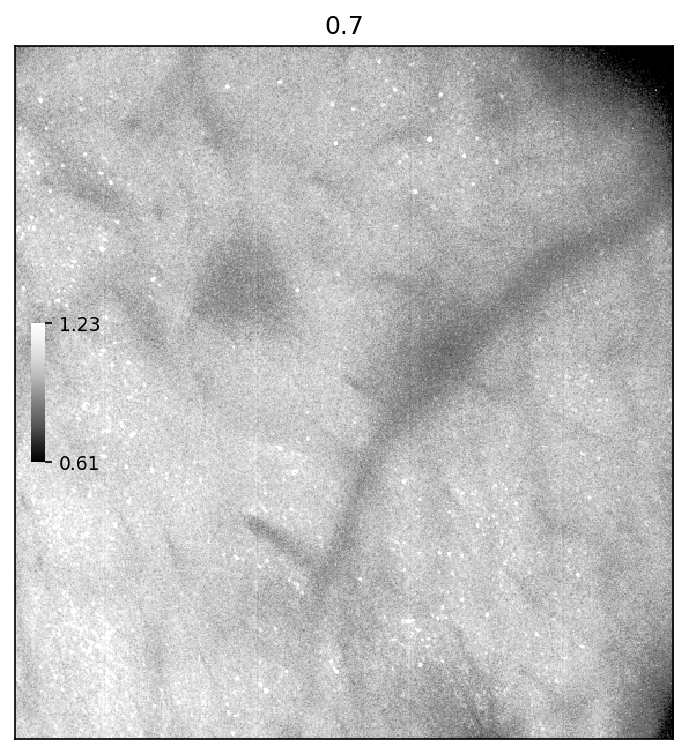

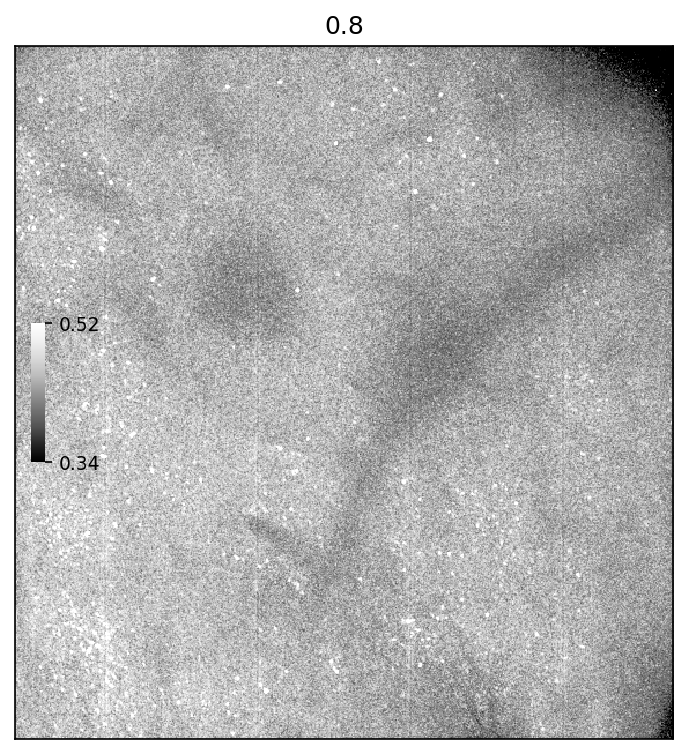

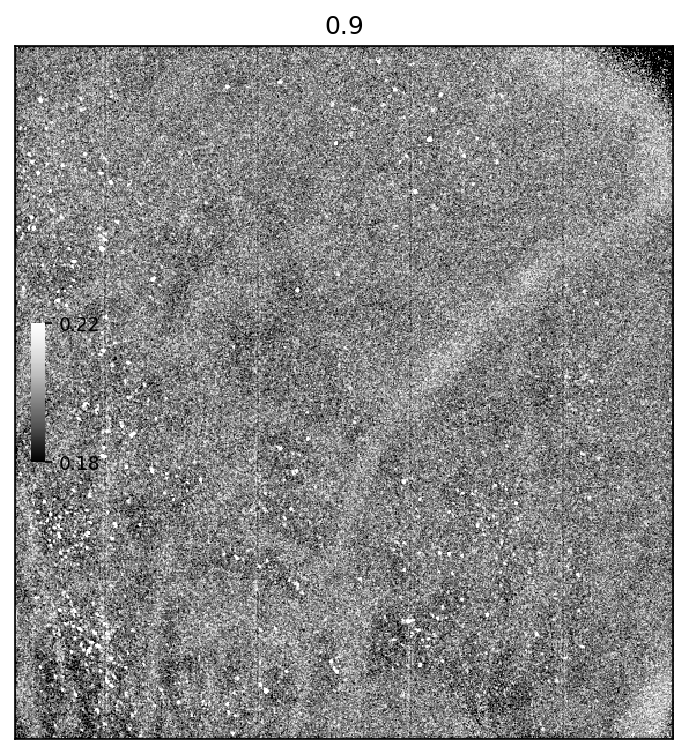

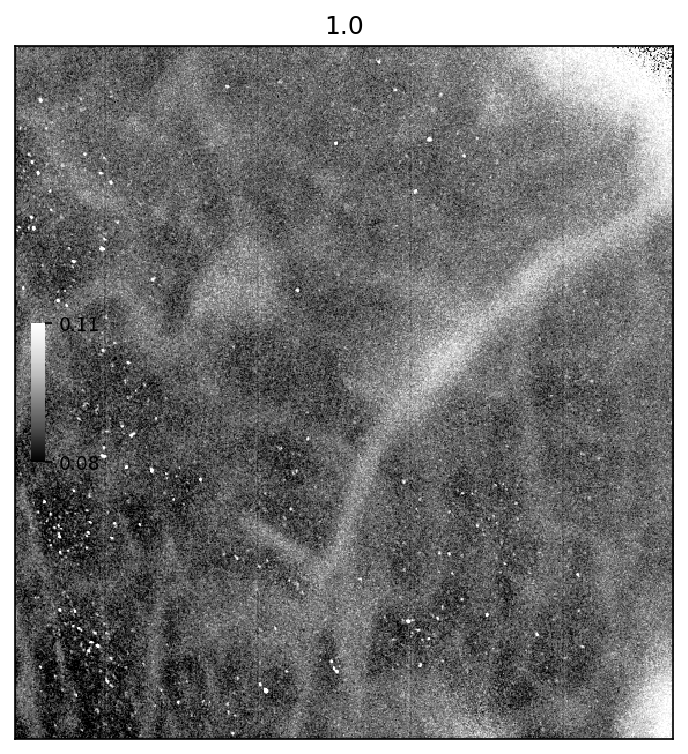

In [307]:
for i,sdmov_exponent in enumerate(sdmov_exponents):
    tfu.show_tif(vmaps[i][0], cbar=True)
    plt.title(sdmov_exponent)
#     plt.title()